# **nanoGPT**

## **Important Contents**
- [The Bigram Model](#simple-bigram-model)
- [The Transformer Architecture](#using-a-transformer-architecture)
  - [Implementation](#implementation)
  - [Fine Tuning](#fine-tuning)
  - [Results](#results)
  - [Generation](#generation)
  - [Reflection](#reflection)

In [1]:
%pip install torchinfo
%pip install torch
%pip install tqdm

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [3]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2026-01-12 01:21:55--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt.3’

input.txt.3         100%[===================>]   1.06M  --.-KB/s    in 0.05s   

2026-01-12 01:21:55 (20.5 MB/s) - ‘input.txt.3’ saved [1115394/1115394]



In [4]:
with open('input.txt') as f:
  text = f.read()

In [5]:
print(len(text))
print(text[:200])

1115394
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you


In [6]:
vocab = sorted(list(set(text)))
print(''.join(vocab))
print(len(vocab))


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


### **Encodings**
We will simply represent each character in our vocabulary as the index of that character in our vocab.

In [7]:
# For individual characters
stoi = {s: i for i, s in enumerate(vocab)}
itos = {i: s for i, s in enumerate(vocab)}

# For words
encode = lambda x: [stoi[i] for i in x]
decode = lambda x: ''.join([itos[i] for i in x])

temp = encode("Hello, World!")
print(temp)
print(decode(temp))

[20, 43, 50, 50, 53, 6, 1, 35, 53, 56, 50, 42, 2]
Hello, World!


In [8]:
import torch
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:1000])

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59,  1, 49, 52, 53, 61,  1, 15, 39, 47, 59, 57,  1, 25, 39, 56, 41,
      

In [9]:
# Train Test Split
split = int(0.9*len(data))
train_data = data[:split]
val_data = data[split:]

### **Time Dimension**
The time dimension in transformers refers to the context length we look at for each character. This helps in randomizing the training, but still maintaining some important patterns found in the data.

In [10]:
block_size = 8

x = train_data[:block_size]
y = train_data[1:block_size + 1]
for t in range(block_size):
  context = x[:t + 1]
  target = y[t]
  print(f"When input is {context} the target is {target}")

When input is tensor([18]) the target is 47
When input is tensor([18, 47]) the target is 56
When input is tensor([18, 47, 56]) the target is 57
When input is tensor([18, 47, 56, 57]) the target is 58
When input is tensor([18, 47, 56, 57, 58]) the target is 1
When input is tensor([18, 47, 56, 57, 58,  1]) the target is 15
When input is tensor([18, 47, 56, 57, 58,  1, 15]) the target is 47
When input is tensor([18, 47, 56, 57, 58,  1, 15, 47]) the target is 58


### **Batch Dimension**
The training is done in batches as a 3D tensor, which can be efficiently utilized by GPUs.

In [11]:
torch.manual_seed(1337)
batch_size = 4
block_size = 8

def get_batch(split):
  data = train_data if split == "train" else val_data
  
  # Get random indices for the 4 batches
  ix = torch.randint(len(data) - block_size, (batch_size, ))

  # Get 8 blocks each from those 4 batches
  x = torch.stack([data[i: i + block_size] for i in ix])
  y = torch.stack([data[i + 1: i + block_size + 1] for i in ix])

  # We get a (4, 8) tensor, with batches as columns, and blocks as rows.

  return x, y

xb, yb = get_batch('train')

In [12]:
print(xb.shape, "\n", yb.shape)

torch.Size([4, 8]) 
 torch.Size([4, 8])


### **Simple Bigram Model**
Now we implmement a very simple bigram model. This model learns the transformation $f: \{0, 1, \dots V - 1 \} \rightarrow \R^V.$ To do this, we use a $V \times V$ lookup table, where $V$ is the size of our vocabulary, and the values of this table are the parameters we learn during training. This is a character level model, and so the vocabulary consists of all unique characters in our dataset.

In [13]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):
  def __init__(self, vocab_size):
    super().__init__()
    self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

  def forward(self, idx, targets=None):
    logits = self.token_embedding_table(idx)
    
    # logits.shape = B, T, C
    # This adds a C dimensions because for for every block of every batch, 
    #   we predict probability scores for every charcter in our vocab.
    # Pytorch's cross-entropy function wants C to be the second dimension in the logits input, so we reshape.
    
    if (targets is None):
      loss = None

    else:
      B, T, C = logits.shape
      logits = logits.view(B * T, C)
      targets = targets.view(B * T)
      loss = F.cross_entropy(logits, targets)

    return logits, loss
  
  def generate(self, idx, max_new_tokens):
    # idx is (B, T)
    for _ in range(max_new_tokens):
      logits, _ = self(idx)
      logits = logits[:, -1, :]
      probs = F.softmax(logits, dim=1)
      idx_next = torch.multinomial(probs, num_samples=1)
      idx = torch.cat((idx, idx_next), dim=1)
    return idx

vocab_size = len(vocab)  
m = BigramLanguageModel(vocab_size)
out, _ = m(xb, yb)
print(out.shape)

idx = torch.zeros((1, 1), dtype=torch.long)
tokens = m.generate(idx, max_new_tokens=100)[0].tolist()
print(decode(tokens))


torch.Size([32, 65])

SKIcLT;AcELMoTbvZv C?nq-QE33:CJqkOKH-q;:la!oiywkHjgChzbQ?u!3bLIgwevmyFJGUGp
wnYWmnxKWWev-tDqXErVKLgJ


### **Training**

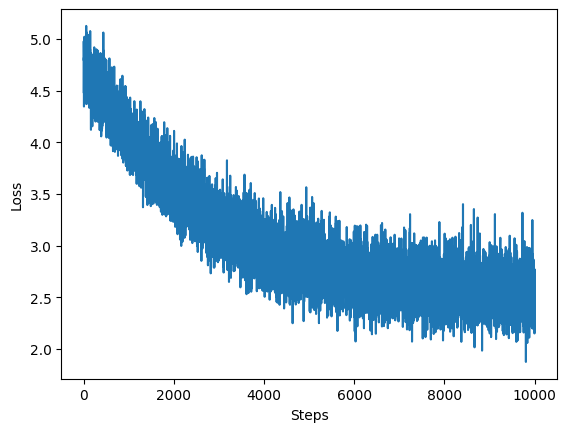

In [14]:
import matplotlib.pyplot as plt

# Typical lr is 3e-4, but for small networks we can use a higher lr
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)
loss_list = []

for steps in range(10000):
  xb, yb = get_batch('train')
  logits, loss = m(xb, yb)
  loss_list.append(loss.item())
  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  optimizer.step()

fig1, ax1 = plt.subplots()
ax1.plot(loss_list)
ax1.set_xlabel("Steps")
ax1.set_ylabel("Loss")
plt.show()

In [15]:
tokens = m.generate(idx, max_new_tokens=100)[0].tolist()
print(decode(tokens))


LUng:
j?
o f herere s digl y somm d fethal m,
KTIN fl tthane abe fls th un,
AD3XEr tidsethe n, or d 


### **Reflection**
Since this model is very simple and does not have a lot of learnable parameters, it doesn't do very well. Yet, we can atleast see some structure in the output- it seems to be arranged much like the Shakespeare examples that we fed the model.

## **Using a Transformer Architecture**
To improve performance, we will use a transformer architecture. This architecture is much better than a bigram model because it has a lot more learnable paramters, better encodes the relationship between characters in the vocabulary and so has better understanding of context, and also encodes positional context. So, it captures a lot more of the principal features of basic human language, and is able to better replicate it than the bigram model.

### **Masking Future Values**
In order for the training to mimic generation, we need to mask future tokens so that any current token cannot see what will have next. <br>
We can do this by simply making a diagonal matrix.
$$
  \begin{bmatrix}
    0.56 & 0 & 0\\
    0.56 & 0.55 & 0\\
    0.56 & 0.55 & 0.48\\
  \end{bmatrix}
$$
We do this by filling in $-\inf$ in the ${QK^T} \over {\sqrt{d_k}}$ matrix so as to create a triangular matrix as shown above. Then after applying softmax, all indices having $- \infty$ get evaluted to 0.
<br><br>
In Python, this can be easily achieved by using a few built-in functions from PyTorch. \\
First, we create a triangular matrix having only 1s and 0s using

```python
helper = torch.tril(torch.ones(T, T))
```

Then, we multiply the ${QK^T} \over {\sqrt{d_k}}$ matrix with the `helper` matrix from above, and use `masked_fill` to fill in all 0s for $- \inf$.

```python
a2 = qktdk.masked_fill(helper == 0, float('inf'))
```

In [16]:
"""
This code cell is an example of masking.
"""

EMB_SIZE = 3

helper = torch.tril(torch.ones((EMB_SIZE, EMB_SIZE)))
a1 = torch.ones((EMB_SIZE, EMB_SIZE)) * 4.56
# masking future values
a2 = a1.masked_fill(helper == 0, float('inf'))

print(f"helper = {helper.shape}\n a1 = {a1.shape}, a2 = {a2.shape}")
print(a2)

helper = torch.Size([3, 3])
 a1 = torch.Size([3, 3]), a2 = torch.Size([3, 3])
tensor([[4.5600,    inf,    inf],
        [4.5600, 4.5600,    inf],
        [4.5600, 4.5600, 4.5600]])


**Imports**

In [17]:
import torch.nn.functional as F
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [18]:
!nvidia-smi

Mon Jan 12 01:22:08 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   30C    P0             53W /  400W |     885MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [28]:
# hyperparameters

BLOCK_SIZE = 256
BATCH_SIZE = 64
EMB_SIZE = 256
VOCAB_SIZE = 65 # Fixed
NUM_BLOCKS = 6

print(len(text))

1115394


### **Implementation**

In [29]:
class Decoder(nn.Module):
  def __init__(self, T: int, h: int):
    super().__init__()

    self.T = T
    self.h = h
    self.d_k = EMB_SIZE // h

    self.W_q = nn.Linear(EMB_SIZE, self.d_k, bias=False)
    self.W_k = nn.Linear(EMB_SIZE, self.d_k, bias=False)
    self.W_v = nn.Linear(EMB_SIZE, self.d_k, bias=False)

    self.encoder_norm1 = nn.LayerNorm(self.d_k, bias=False)
    self.encoder_norm2 = nn.LayerNorm(self.d_k, bias=False)
    self.decoder_norm1 = nn.LayerNorm(self.d_k, bias=False)
    self.decoder_norm2 = nn.LayerNorm(self.d_k, bias=False)
    self.decoder_norm3 = nn.LayerNorm(self.d_k, bias=False)

    self.feed_forward = nn.Sequential(
                          nn.Linear(EMB_SIZE, 4*EMB_SIZE),
                          nn.GELU(),
                          nn.Linear(4*EMB_SIZE, EMB_SIZE)
                        )
    
    self.norm1 = nn.LayerNorm(EMB_SIZE, device=device)
    self.norm2 = nn.LayerNorm(EMB_SIZE, device=device)
    self.proj = nn.Linear(h * self.d_k, EMB_SIZE)
    
  def _self_attention(self, 
                      Q: torch.Tensor, 
                      K: torch.Tensor, 
                      V: torch.Tensor, 
                      mask: bool = False):
    
    _, T, _ = Q.shape
    a1 = torch.bmm(Q, K.transpose(1, 2)) / ((self.d_k) ** (1/2))

    if (mask):
      # masking future values
      helper = torch.tril(torch.ones((T, T), device=Q.device))
      a1 = a1.masked_fill(helper == 0, float('-inf'))

    a2 = F.softmax(a1, dim=-1)
    attention = torch.bmm(a2, V)
    return attention
  
  def _multi_head_attention(self, 
                            Q: torch.Tensor, 
                            K: torch.Tensor, 
                            V: torch.Tensor, 
                            mask: bool = False):
    
    b1 = [self._self_attention(Q, K, V, mask) for h in range(self.h)]
    b2 = torch.cat(b1, dim=-1)
    mh_attention = self.proj(b2)
    return mh_attention
  
  def _add_and_norm(self, 
                    x1: torch.Tensor, 
                    x2: torch.Tensor,
                    norm_layer: torch.nn.Module):
    
    a = x1 + x2
    return norm_layer(a)
  
  
  # def encoder(self, 
  #             x: torch.Tensor):
    
  #   Q, K, V = self.W_q(x), self.W_k(x), self.W_v(x)

  #   mh_out = self._multi_head_attention(Q, K, V)
  #   add_norm_out1 = self._add_and_norm(x, mh_out)

  #   ff_out = self.feed_forward(add_norm_out1)
  #   add_norm_out2 = self._add_and_norm(add_norm_out1, ff_out)

  #   return add_norm_out2
  
  def forward(self, 
              x: torch.Tensor, 
              encoder_out: torch.Tensor | None = None
              ):
    
    Q, K, V = self.W_q(x), self.W_k(x), self.W_v(x)

    mh_out1 = self._multi_head_attention(Q, K, V, mask=True)
    add_norm_out1 = self._add_and_norm(x, mh_out1, self.norm1) # (B, T, C)

    # mh_out2 = self._multi_head_attention(encoder_out, encoder_out, add_norm_out1)
    # add_norm_out2 = self._add_and_norm(add_norm_out1, mh_out2)

    ff_out = self.feed_forward(add_norm_out1)
    add_norm_out3 = self._add_and_norm(add_norm_out1, ff_out, self.norm2)

    return add_norm_out3
  
  
class ShakespeareGPT(nn.Module):
  def __init__(self, T, h, num_blocks):
    super().__init__()

    self.T = T
    self.h = h

    self.get_token_embeddings = nn.Embedding(VOCAB_SIZE, EMB_SIZE)
    self.get_pos_embeddings = nn.Embedding(self.T, EMB_SIZE)

    self.lm_head = nn.Linear(EMB_SIZE, VOCAB_SIZE)

    self.decoder_blocks = nn.ModuleList([
      Decoder(T, h) for _ in range(num_blocks)
    ])

  def forward(self, 
            X: torch.Tensor, 
            Y: torch.Tensor | None = None
            ):
  
    loss = None
    
    B, T = X.shape
    
    tok_emb = self.get_token_embeddings(X) # x.shape = B, T, C
    pos_emb = self.get_pos_embeddings(torch.arange(T, device=X.device))
    x = tok_emb + pos_emb

    # encoder_out = self.encoder(x)
    for decoder in self.decoder_blocks:
      x = decoder(x)

    logits = self.lm_head(x)
    # logits, loss = F.softmax(logits, dim=-1), None

    if Y is not None:
      B, T, C = logits.shape
      logits = logits.view(B*T, C)
      Y = Y.view(B*T)
      loss = F.cross_entropy(logits, Y)

    return logits, loss

  def generate(self, 
              idx: list[int], 
              max_new_tokens: int
              ):
    
    for _ in range(max_new_tokens):
      block_idx = idx[:, -self.T: ]
      logits, loss = self(block_idx)
      logits = logits[:, -1, :]
      probs = F.softmax(logits, dim=-1)
      
      # Get index with highest probability
      idx_next = torch.multinomial(probs, num_samples=1)
      idx = torch.cat((idx, idx_next), dim=1)

    return idx  


### **Fine Tuning**
This section is a little out of order, since I ran the model several times using different parameters and I settled with the ones two cells defined above.This gives us a model with 3.9M parameters, and running it for 5000 epochs gives us a loss of about 0.4, which is good enough for me in this case.

### **Results**
Now it is time to run the model.

In [30]:
torch.manual_seed(1337)

def get_batch(split):
  data = train_data if split == "train" else val_data
  
  # Get random indices for the BATCH_SIZE batches
  ix = torch.randint(len(data) - BLOCK_SIZE, (BATCH_SIZE, ))

  # Get BLOCK_SIZE blocks each from those BATCH_SIZE batches
  x = torch.stack([data[i: i + BLOCK_SIZE] for i in ix])
  y = torch.stack([data[i + 1: i + BLOCK_SIZE + 1] for i in ix])

  # We get a (BATCH_SIZE, BLOCK_SIZE) tensor, with batches as columns, and blocks as rows.
  x, y = x.to(device), y.to(device)

  return x, y

xb, yb = get_batch('train')

In [31]:
from torchinfo import summary

model = ShakespeareGPT(T=BLOCK_SIZE, h=4, num_blocks=NUM_BLOCKS)

dummy_x = torch.randint(
    low=0,
    high=VOCAB_SIZE,
    size=(1, 8),
    dtype=torch.long,
    device=device
)

summary(model, input_data=dummy_x, device=device)

Layer (type:depth-idx)                   Output Shape              Param #
ShakespeareGPT                           [1, 8, 65]                --
├─Embedding: 1-1                         [1, 8, 256]               16,640
├─Embedding: 1-2                         [8, 256]                  65,536
├─ModuleList: 1-3                        --                        --
│    └─Decoder: 2-1                      [1, 8, 256]               320
│    │    └─Linear: 3-1                  [1, 8, 64]                16,384
│    │    └─Linear: 3-2                  [1, 8, 64]                16,384
│    │    └─Linear: 3-3                  [1, 8, 64]                16,384
│    │    └─Linear: 3-4                  [1, 8, 256]               65,792
│    │    └─LayerNorm: 3-5               [1, 8, 256]               512
│    │    └─Sequential: 3-6              [1, 8, 256]               525,568
│    │    └─LayerNorm: 3-7               [1, 8, 256]               512
│    └─Decoder: 2-2                      [1, 8, 256] 

In [32]:
from tqdm import tqdm

model = ShakespeareGPT(T=BLOCK_SIZE, h=4, num_blocks=NUM_BLOCKS)

m = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

for epoch in tqdm(range(5000), desc='Training'):
  xb, yb = get_batch('train')
  logits, loss = model(xb, yb)
  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  optimizer.step()
  tqdm.write(f"Epoch {epoch}, Loss: {loss.item():.4f}") if epoch % 100 == 0 else None

Training:   0%|          | 3/5000 [00:00<08:05, 10.29it/s]

Epoch 0, Loss: 4.3104


Training:   2%|▏         | 103/5000 [00:08<06:28, 12.61it/s]

Epoch 100, Loss: 2.4497


Training:   4%|▍         | 203/5000 [00:16<06:19, 12.65it/s]

Epoch 200, Loss: 2.1401


Training:   6%|▌         | 303/5000 [00:24<06:12, 12.60it/s]

Epoch 300, Loss: 1.8193


Training:   8%|▊         | 403/5000 [00:31<06:03, 12.66it/s]

Epoch 400, Loss: 1.6188


Training:  10%|█         | 503/5000 [00:39<05:55, 12.64it/s]

Epoch 500, Loss: 1.5059


Training:  12%|█▏        | 603/5000 [00:47<05:51, 12.52it/s]

Epoch 600, Loss: 1.4473


Training:  14%|█▍        | 703/5000 [00:55<05:40, 12.61it/s]

Epoch 700, Loss: 1.3596


Training:  16%|█▌        | 803/5000 [01:03<05:31, 12.65it/s]

Epoch 800, Loss: 1.3070


Training:  18%|█▊        | 903/5000 [01:11<05:28, 12.48it/s]

Epoch 900, Loss: 1.2804


Training:  20%|██        | 1003/5000 [01:19<05:15, 12.69it/s]

Epoch 1000, Loss: 1.2706


Training:  22%|██▏       | 1103/5000 [01:27<05:07, 12.68it/s]

Epoch 1100, Loss: 1.2640


Training:  24%|██▍       | 1203/5000 [01:35<05:01, 12.58it/s]

Epoch 1200, Loss: 1.2002


Training:  26%|██▌       | 1303/5000 [01:43<04:50, 12.74it/s]

Epoch 1300, Loss: 1.1680


Training:  28%|██▊       | 1403/5000 [01:50<04:45, 12.60it/s]

Epoch 1400, Loss: 1.1675


Training:  30%|███       | 1503/5000 [01:58<04:35, 12.70it/s]

Epoch 1500, Loss: 1.1493


Training:  32%|███▏      | 1603/5000 [02:06<04:27, 12.70it/s]

Epoch 1600, Loss: 1.1340


Training:  34%|███▍      | 1703/5000 [02:14<04:19, 12.70it/s]

Epoch 1700, Loss: 1.1118


Training:  36%|███▌      | 1803/5000 [02:22<04:12, 12.64it/s]

Epoch 1800, Loss: 1.0584


Training:  38%|███▊      | 1903/5000 [02:30<04:06, 12.54it/s]

Epoch 1900, Loss: 1.0221


Training:  40%|████      | 2003/5000 [02:38<03:57, 12.63it/s]

Epoch 2000, Loss: 1.0280


Training:  42%|████▏     | 2103/5000 [02:46<03:50, 12.59it/s]

Epoch 2100, Loss: 0.9584


Training:  44%|████▍     | 2203/5000 [02:54<03:43, 12.49it/s]

Epoch 2200, Loss: 0.9604


Training:  46%|████▌     | 2303/5000 [03:02<03:33, 12.63it/s]

Epoch 2300, Loss: 0.9374


Training:  48%|████▊     | 2403/5000 [03:10<03:25, 12.64it/s]

Epoch 2400, Loss: 0.9231


Training:  50%|█████     | 2503/5000 [03:17<03:18, 12.57it/s]

Epoch 2500, Loss: 0.8737


Training:  52%|█████▏    | 2603/5000 [03:25<03:09, 12.68it/s]

Epoch 2600, Loss: 0.8697


Training:  54%|█████▍    | 2703/5000 [03:33<03:00, 12.70it/s]

Epoch 2700, Loss: 0.8559


Training:  56%|█████▌    | 2803/5000 [03:41<02:53, 12.68it/s]

Epoch 2800, Loss: 0.8037


Training:  58%|█████▊    | 2903/5000 [03:49<02:45, 12.67it/s]

Epoch 2900, Loss: 0.7847


Training:  60%|██████    | 3003/5000 [03:57<02:38, 12.63it/s]

Epoch 3000, Loss: 0.7609


Training:  62%|██████▏   | 3103/5000 [04:05<02:31, 12.51it/s]

Epoch 3100, Loss: 0.7014


Training:  64%|██████▍   | 3203/5000 [04:13<02:23, 12.49it/s]

Epoch 3200, Loss: 0.6929


Training:  66%|██████▌   | 3303/5000 [04:21<02:13, 12.71it/s]

Epoch 3300, Loss: 0.7133


Training:  68%|██████▊   | 3403/5000 [04:29<02:06, 12.65it/s]

Epoch 3400, Loss: 0.6604


Training:  70%|███████   | 3503/5000 [04:36<01:59, 12.49it/s]

Epoch 3500, Loss: 0.6517


Training:  72%|███████▏  | 3603/5000 [04:44<01:50, 12.64it/s]

Epoch 3600, Loss: 0.6096


Training:  74%|███████▍  | 3703/5000 [04:52<01:42, 12.64it/s]

Epoch 3700, Loss: 0.6306


Training:  76%|███████▌  | 3803/5000 [05:00<01:35, 12.54it/s]

Epoch 3800, Loss: 0.5954


Training:  78%|███████▊  | 3903/5000 [05:08<01:26, 12.62it/s]

Epoch 3900, Loss: 0.5442


Training:  80%|████████  | 4003/5000 [05:16<01:19, 12.55it/s]

Epoch 4000, Loss: 0.5476


Training:  82%|████████▏ | 4103/5000 [05:24<01:11, 12.59it/s]

Epoch 4100, Loss: 0.5276


Training:  84%|████████▍ | 4203/5000 [05:32<01:03, 12.64it/s]

Epoch 4200, Loss: 0.5174


Training:  86%|████████▌ | 4303/5000 [05:40<00:54, 12.69it/s]

Epoch 4300, Loss: 0.4930


Training:  88%|████████▊ | 4403/5000 [05:48<00:47, 12.58it/s]

Epoch 4400, Loss: 0.4724


Training:  90%|█████████ | 4503/5000 [05:55<00:39, 12.48it/s]

Epoch 4500, Loss: 0.4422


Training:  92%|█████████▏| 4603/5000 [06:03<00:31, 12.65it/s]

Epoch 4600, Loss: 0.4703


Training:  94%|█████████▍| 4703/5000 [06:11<00:23, 12.66it/s]

Epoch 4700, Loss: 0.4436


Training:  96%|█████████▌| 4803/5000 [06:19<00:15, 12.43it/s]

Epoch 4800, Loss: 0.4281


Training:  98%|█████████▊| 4903/5000 [06:27<00:07, 12.59it/s]

Epoch 4900, Loss: 0.4115


Training: 100%|██████████| 5000/5000 [06:35<00:00, 12.65it/s]


### **Generation**

In [33]:
context = torch.zeros((1, 1), dtype=torch.long, device=device)
# m.generate(context, max_new_tokens=2000)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))



COMINIUS:
O, will dost those badren ourselves,
The common vast flood hap to your grace
From gibines worship, for the modest moon
Upon this hour, marching to command;
Only red the rank of this kingly violent.
See, how now, which fair deputy,
Dightsing fright hay. Usuff into thisding Margares?
Are they letter hem mine, their tongues have for ever.

KATHARINA:
An's we suppose so.
3 repare her, I talk of this: I slain
Sometime companion blots to serve our hands:
O that once cannot be forsworn.
Now, break, soft! what news? Warest hast thou with thee?
'Tis believe that resign thine own son,
Thou counterfeit'st me; this is an end.

KING HENRY VI:
Ah, know you not when you shall be my son:
Hidest grace the away: laid thy anchorse look
From my former hands.

FRIAR LAURENCE:
Where is the business of the king?

PARIS:
Monday, my lord.

JULIET:
What is my office, sir?

JULIET:
Go thou queate the casafe, and my friend Norfolk
Upon some more piece with an agazem. Take good counsellor.

PRINCE EDWA

### **Reflection**
I think this is a very good result given the small scale of the project. This model has about 4M parameters, and with further fine-tuning it can do even better.